In [25]:
from itertools import combinations
import numpy as np
import pandas as pd
import dcor

In [2]:
def flatten(tup):
    """ 
    Flatten any nested tuple
    """
    if len(tup) < 1:
        return tup 
    if isinstance(tup[0], tuple):
        return flatten(tup[0]) + flatten(tup[1:])
    return tup[:1] + flatten(tup[1:])


def calc_shapley_value(player_index, all_players, cf_dict):
    """
    Calculate the Shapley value for player index
    Input:
        all_players, list of player indices
        cf_dict, dictionary containing characteristic function values for all players
    """
    players = all_players.copy()

    if player_index in players:
        players.remove(player_index)

    num_players = len(players)
    coalition_sizes = list(range(num_players+1))
    value = 0
    player_tuple = (player_index,)

    for _size in coalition_sizes:
        coalition_value = 0
        coalitions_of_size_s = list(combinations(players, _size))
        for _coalition in coalitions_of_size_s:
            value_in_coalition = (cf_dict[tuple(sorted(_coalition + player_tuple))] - cf_dict[_coalition])
            coalition_value += value_in_coalition

        average_coalition_value = coalition_value/len(coalitions_of_size_s)
        value += average_coalition_value
    average_value = value/len(coalition_sizes)

    return average_value

def calc_shapley_values(x, y, cf_dict):
    """
    Returns the shapley values for features x and labels y, given a
    characteristic function (default dcor)
    """
    
    players = list(range(x.shape[1]))
    shapley_values = []
    for _player in players:
        shapley_values.append(calc_shapley_value(_player, players, cf_dict))
    return shapley_values

def make_cf_dict(x, y, characteristic_function):
    """ 
    Creates dictionary with values of the characteristic function for each
    combination of the players.
    """
    cf_dict = {}
    num_players = x.shape[1]
    players = list(range(num_players))
    coalition_sizes = list(range(num_players+1))

    for _size in coalition_sizes:
        coalitions_of_size_s = list(combinations(players, _size))
        for _coalition in coalitions_of_size_s:
            _coalition = tuple(sorted(flatten(_coalition)))
            cf_dict[_coalition] = characteristic_function(x, y, _coalition)

    return cf_dict

# Explaining data

### Cab sharing example

In [3]:
players = [1,2,3]
cf_dict = {():0, (1,):3, (2,):7, (3,):10, (1,2):7, (1,3):10, (2,3):10, (1,2,3):10}
print(calc_shapley_value(1, players, cf_dict))
print(calc_shapley_value(2, players, cf_dict))
print(calc_shapley_value(3, players, cf_dict))

1.0
3.0
6.0


### Cat and mice example

## Task 1 (Shapley values for cats)

In [4]:
players = [1,2,3]
cf_dict = {():0, (1,):2, (2,):4, (3,):5, (1,2):3, (1,3):3, (2,3):2, (1,2,3):3}
print(calc_shapley_value(1, players, cf_dict))
print(calc_shapley_value(2, players, cf_dict))
print(calc_shapley_value(3, players, cf_dict))

0.5
1.0
1.5


## Boston Housing

In [26]:
from sklearn.datasets import load_boston
boston = load_boston()
#print(boston.keys()) # print all keys
#print(boston.DESCR) # print feature descriptions
#print(boston.feature_names) # print all feature names

In [27]:
boston_dataset = pd.DataFrame(boston.data, columns=boston.feature_names)
boston_dataset['MEDV'] =  boston.target

#features_to_use = ["RM", "AGE", "TAX", "CRIM", "PTRATIO"]
features_to_use = boston.feature_names
x_data = np.array(boston_dataset[features_to_use])
y_data = np.array(boston_dataset.MEDV)

#print(x_data)
#print(y_data)

In [7]:
def characteristic_function_r2(x, y, coalition):
    """
    Returns the characteristic function value (currently the coefficient of determination)
    Input:
        x, numpy array shape (#samples, #features)        
        y, numpy array shape (#samples, )
        coalition, tuple of indices of features to include
    """
    if len(coalition)==0:
        return 0.0
    x = x[:, coalition]
    
    # --- Coefficient of determination, R2
    det_C_xy = np.linalg.det(np.corrcoef(x.T, y))
    if len(coalition)==1:
        det_C_x = 1
    else:
        det_C_x = np.linalg.det(np.corrcoef(x.T))

    return (1 - det_C_xy/det_C_x)

In [8]:
cf_dict_R2 = make_cf_dict(x_data, y_data, characteristic_function_r2)
#print(cf_dict_R2)

## Task 2: What is the Shapley value for AGE? (Leaving the characteristic function R²)

In [9]:
shapley_values = calc_shapley_values(x_data, y_data, cf_dict_R2)
print(shapley_values)

[0.02717563720515923, 0.024810864053603113, 0.037781894503766594, 0.015842593481409678, 0.03341461642888308, 0.18708535056488523, 0.022035236756374525, 0.030277073084646403, 0.023629354981878195, 0.03678938955704263, 0.07852550922791969, 0.02291290035050214, 0.20036224391333862]


In [10]:
print(features_to_use) # AGE index = 6
shapley_values[6]
#print(features_to_use) # AGE index = 2
#shapley_values[2]

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


0.022035236756374525

In [11]:
print(sum(shapley_values))
print(cf_dict_R2[list(cf_dict_R2.keys())[-1]])

0.740642664109409
0.740642664109409


## Task 3: What is the Shapley value for AGE, using another characteristic function?

In [12]:
def characteristic_function_dcor(x, y, coalition):
    if len(coalition)==0:
        return 0.0

    x = x[:, coalition]
    
    # --- Distance correlation in here, pls
    return dcor.distance_correlation(x,y)

In [13]:
cf_dict_dcor = make_cf_dict(x_data, y_data, characteristic_function_dcor)
#print(cf_dict_dcor)

In [14]:
shapley_values_dcor = calc_shapley_values(x_data, y_data, cf_dict_dcor)
print(shapley_values_dcor[6])

0.03709735338519654


In [15]:
def sort_shapley_values(values, features):
    return zip(*sorted(zip(values, features), reverse=True))

In [16]:
_, sorted_features = sort_shapley_values(shapley_values, features_to_use)
print(sorted_features)
_, sorted_features_dcor = sort_shapley_values(shapley_values_dcor, features_to_use)
print(sorted_features_dcor)

('LSTAT', 'RM', 'PTRATIO', 'INDUS', 'TAX', 'NOX', 'DIS', 'CRIM', 'ZN', 'RAD', 'B', 'AGE', 'CHAS')
('LSTAT', 'TAX', 'RM', 'INDUS', 'PTRATIO', 'CRIM', 'NOX', 'AGE', 'RAD', 'DIS', 'ZN', 'CHAS', 'B')


# Explaining a model

In [28]:
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [29]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=42)

regressor = xgboost.XGBRegressor()
regressor.fit(x_train, y_train);

In [30]:
y_pred = regressor.predict(x_test)

In [20]:
cf_dict_dcor_targets = make_cf_dict(x_test, y_test, characteristic_function_dcor)
shapley_values_targets = calc_shapley_values(x_test, y_test, cf_dict_dcor_targets)

In [21]:
cf_dict_dcor_preds = make_cf_dict(x_test, y_pred, characteristic_function_dcor)
shapley_values_preds = calc_shapley_values(x_test, y_pred, cf_dict_dcor_preds)

In [22]:
def plot_shapley_comparison(values_0, values_1,feature_names=None, nametags=[0,1]):
    assert len(values_0) == len(values_1)
    num = range(1,len(values_0)+1)
    colors = ["blue", "pink"]
    
    for _n, _values in enumerate([values_0, values_1]):
        _col = colors[_n]
        plt.scatter(num,_values,c=_col,marker='s',alpha=0.7,label=f"Shapley values {nametags[_n]}")

    plt.ylabel("Shapley decomposition")
    plt.legend()
    if feature_names is not None:
        ax = plt.gca()
        ax.set_xticks(num)
        ax.set_xticklabels(feature_names,rotation=45)
    plt.show()

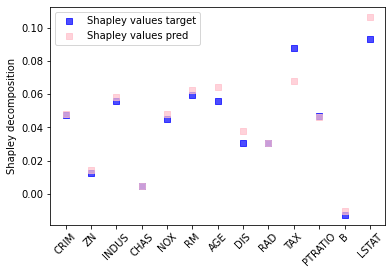

In [23]:
plot_shapley_comparison(shapley_values_targets, shapley_values_preds, features_to_use, ["target", "pred"])

### Evaluate regressor

In [33]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.9971486063060648
Mean Squared Error: 9.107074616298476
Root Mean Squared Error: 3.017793004216571


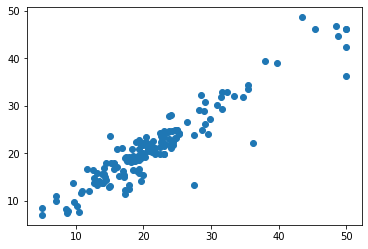

In [34]:
plt.scatter(y_test, y_pred)
plt.show()

In [35]:
print(np.mean(y_test))

21.643712574850298


In [37]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

Actual  Predicted
0      23.6  24.585991
1      32.4  32.865677
2      13.6  13.956607
3      22.8  23.179035
4      16.1  17.136997
..      ...        ...
162    21.7  21.208731
163    23.1  24.710854
164    22.8  22.328720
165    21.0  20.590370
166    48.8  44.667843

[167 rows x 2 columns]